# Plot $t\bar{t}$ Events

This notebook allows one to visualize events, including jets and the genParticles they are matched to. Trees from events are also printed using the `printTrees` method in `utils`.

In [1]:
# IMPORTS
from coffea.nanoevents import NanoEventsFactory
import numpy as np
import matplotlib.pyplot as plt
import awkward as ak
import particle
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

In [2]:
# file must be nanoAOD
filepath = "https://xrootd-local.unl.edu:1094//store/user/AGC/nanoAOD/TT_TuneCUETP8M1_13TeV-powheg-pythia8/cmsopendata2015_ttbar_19980_PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1_00000_0004.root"
# process events into NanoAODSchema
events = NanoEventsFactory.from_root(filepath, 
                                     treepath="Events", 
                                     entry_stop=50000).events()

/opt/conda/lib/python3.8/site-packages/coffea/nanoevents/schemas/nanoaod.py:201: RuntimeWarning: Missing cross-reference index for FatJet_subJetIdx1 => SubJet
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/coffea/nanoevents/schemas/nanoaod.py:201: RuntimeWarning: Missing cross-reference index for FatJet_subJetIdx2 => SubJet
  warnings.warn(


In [3]:
# filter electrons, muons by pT
selected_electrons = events.Electron[events.Electron.pt > 25]
selected_muons = events.Muon[events.Muon.pt > 25]

# filter jets by pT
jet_filter = events.Jet.pt > 25
selected_jets = events.Jet[jet_filter]

# get genParticles
selected_genpart = events.GenPart

# single lepton requirement
event_filters = ((ak.count(selected_electrons.pt, axis=1) + ak.count(selected_muons.pt, axis=1)) == 1)

# at least four jets
event_filters = event_filters & (ak.count(selected_jets.pt, axis=1) >= 4)

# at least one b-tagged jet ("tag" means score above threshold)
B_TAG_THRESHOLD = 0.5
event_filters = event_filters & (ak.sum(selected_jets.btagCSVV2 >= B_TAG_THRESHOLD, axis=1) >= 1)

# apply event filters
selected_events = events[event_filters]
selected_electrons = selected_electrons[event_filters]
selected_muons = selected_muons[event_filters]
selected_jets = selected_jets[event_filters]
selected_genpart = selected_genpart[event_filters]

# consider 4j2b region (at least 4 jets, >=2 b-tagged jets)
region_filter = ak.sum(selected_jets.btagCSVV2 > B_TAG_THRESHOLD, axis=1) >= 2
selected_jets_region = selected_jets[region_filter][:,:4]
selected_electrons_region = selected_electrons[region_filter]
selected_muons_region = selected_muons[region_filter]
selected_genpart_region = selected_genpart[region_filter]

In [4]:
## filter genParticles to "matchable" particles

# make sure parent is not None
genpart_parent = selected_genpart_region.distinctParent
genpart_filter = np.invert(ak.is_none(genpart_parent, axis=1))
selected_genpart_region_reduced = selected_genpart_region[genpart_filter]
genpart_parent_reduced = selected_genpart_region_reduced.distinctParent

# parent must be top quark or W boson
genpart_filter2 = ((np.abs(genpart_parent_reduced.pdgId)==6) | 
                   (np.abs(genpart_parent_reduced.pdgId)==24))
selected_genpart_region_reduced = selected_genpart_region_reduced[genpart_filter2]

# make sure particle is a quark
genpart_filter3 = ((np.abs(selected_genpart_region_reduced.pdgId)<9) & 
                   (np.abs(selected_genpart_region_reduced.pdgId)>0))
selected_genpart_region_reduced = selected_genpart_region_reduced[genpart_filter3]

# get rid of copies
genpart_filter4 = selected_genpart_region_reduced.hasFlags("isLastCopy")
selected_genpart_region_reduced = selected_genpart_region_reduced[genpart_filter4]

In [5]:
# plotting candidates include daughters of t/W or t/W (remove copies) 
plotting_candidates = selected_genpart_region[genpart_filter]
genpart_filter_plotting = ((((np.abs(plotting_candidates.pdgId)<=5) & 
                           ((np.abs(plotting_candidates.distinctParent.pdgId)==24) | 
                            (np.abs(plotting_candidates.distinctParent.pdgId)==6))) | 
                           (np.abs(plotting_candidates.pdgId)==24) | 
                            (np.abs(plotting_candidates.pdgId)==6)) & 
                           (plotting_candidates.hasFlags("isLastCopy")) & 
                           (np.abs(plotting_candidates.pdgId)>0))
plotting_candidates = plotting_candidates[genpart_filter_plotting]

In [6]:
# list of all quarks (no requirement on parentage)
quark_filter = ((np.abs(selected_genpart_region.pdgId)<=9) & 
                      selected_genpart_region.hasFlags("isLastCopy"))
all_quarks= selected_genpart_region[quark_filter]

In [7]:
# find labels using pdgid of parent of nearest genPart
nearest_genpart = selected_jets_region.nearest(selected_genpart_region_reduced, 
                                               threshold=0.4)
nearest_parent = nearest_genpart.distinctParent
nearest_parent_pdgid = nearest_parent.pdgId

In [8]:
parent_pdgid = nearest_parent.pdgId # pdgId of parent particle
grandchild_pdgid = nearest_parent.distinctChildren.distinctChildren.pdgId # pdgId of particle's parent's grandchildren

grandchildren_flat = np.abs(ak.flatten(grandchild_pdgid,axis=-1)) # flatten innermost axis for convenience

# if particle has a cousin that is a lepton
has_lepton_cousin = (ak.sum(((grandchildren_flat%2==0) & 
                             (grandchildren_flat>10) & 
                             (grandchildren_flat<19)) ,axis=-1)>0)
# if particle has a cousin that is a neutrino
has_neutrino_cousin = (ak.sum(((grandchildren_flat%2==1) & 
                               (grandchildren_flat>10) & 
                               (grandchildren_flat<19)) ,axis=-1)>0)

# if a particle has a lepton cousin and a neutrino cousin
has_both_cousins = ak.fill_none((has_lepton_cousin & has_neutrino_cousin), False).to_numpy()

# get labels from parent pdgId (fill none with 100 to filter out events with those jets)
labels = np.abs(ak.fill_none(parent_pdgid,100).to_numpy())
labels[has_both_cousins] = -6 # assign jets with both cousins as top1 (not necessarily antiparticle)

training_event_filter = (np.sum(labels,axis=1)==48) # events with a label sum of 48 have the correct particles
            
# filter events
selected_jets_region = selected_jets_region[training_event_filter]
selected_electrons_region = selected_electrons_region[training_event_filter]
selected_muons_region = selected_muons_region[training_event_filter]
plotting_candidates = plotting_candidates[training_event_filter]
all_quarks = all_quarks[training_event_filter]
labels = labels[training_event_filter]
nearest_genpart = nearest_genpart[training_event_filter]
nearest_parent = nearest_parent[training_event_filter]
nearest_parent_pdgid = nearest_parent_pdgid[training_event_filter]

In [9]:
# jet colors for plotting
jetcolors = ['brown','red','orange',
             'darkgreen','teal','dodgerblue',
             'blue','blueviolet','purple','deeppink']

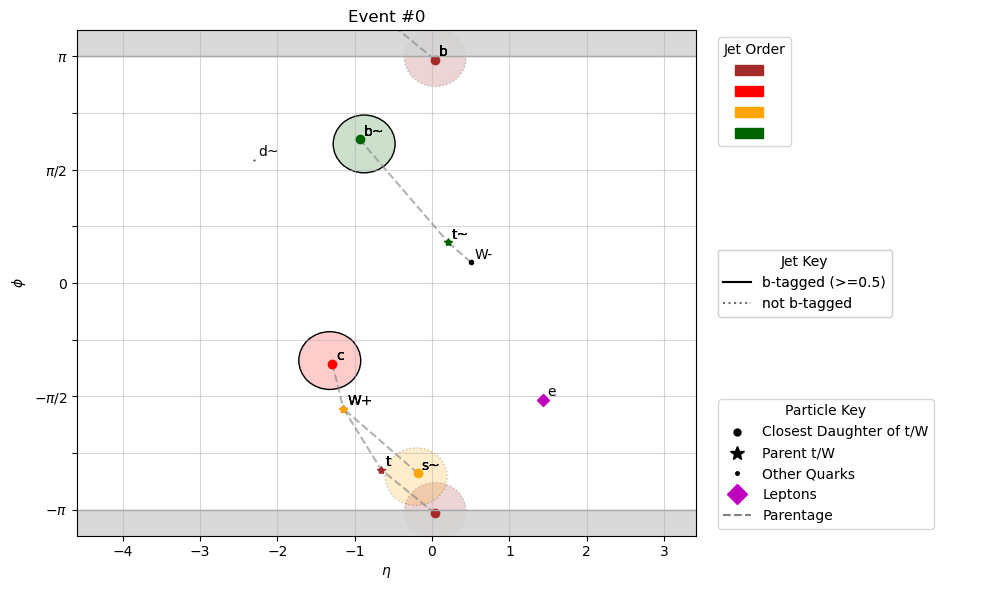

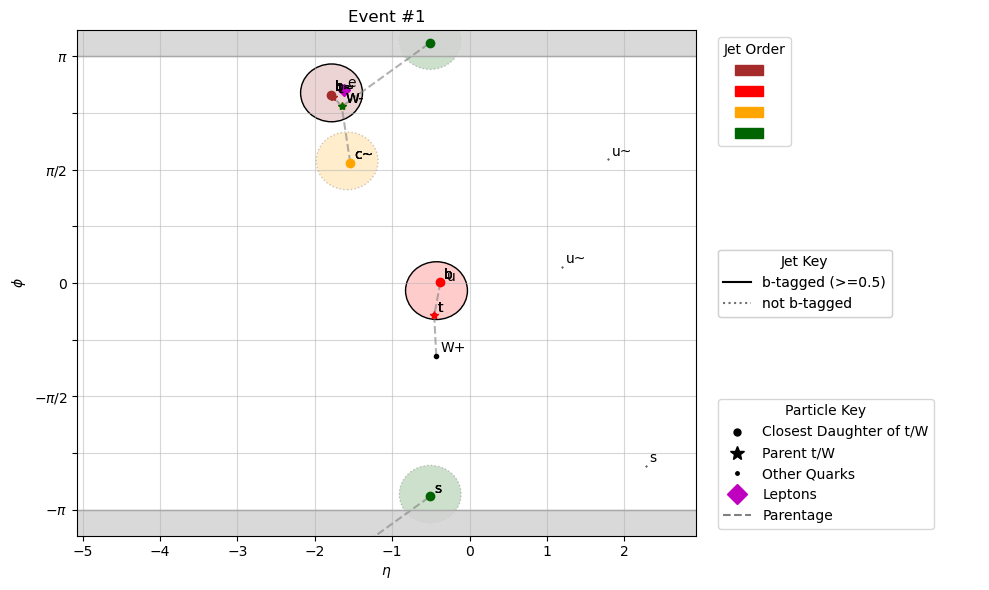

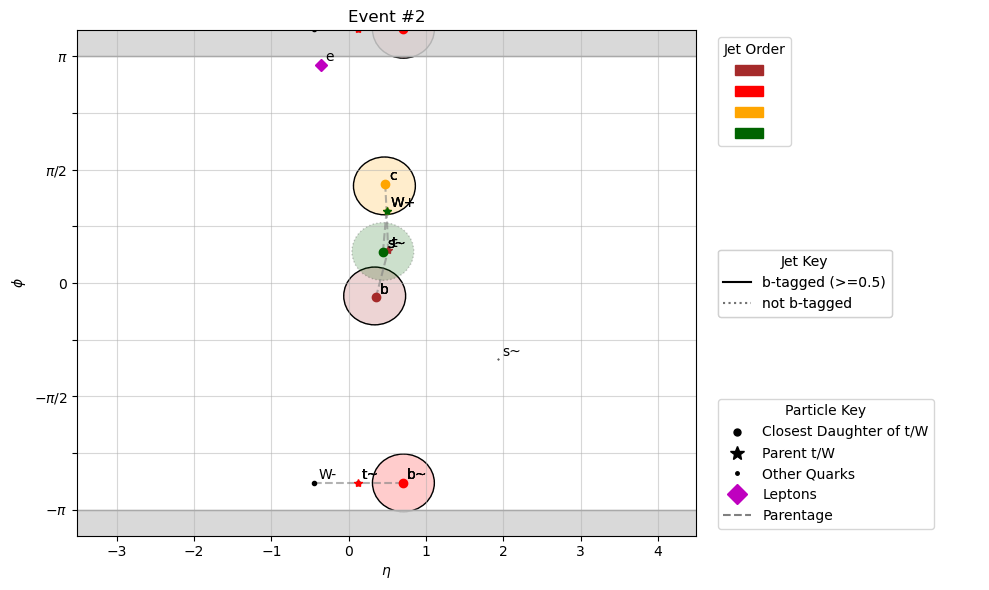

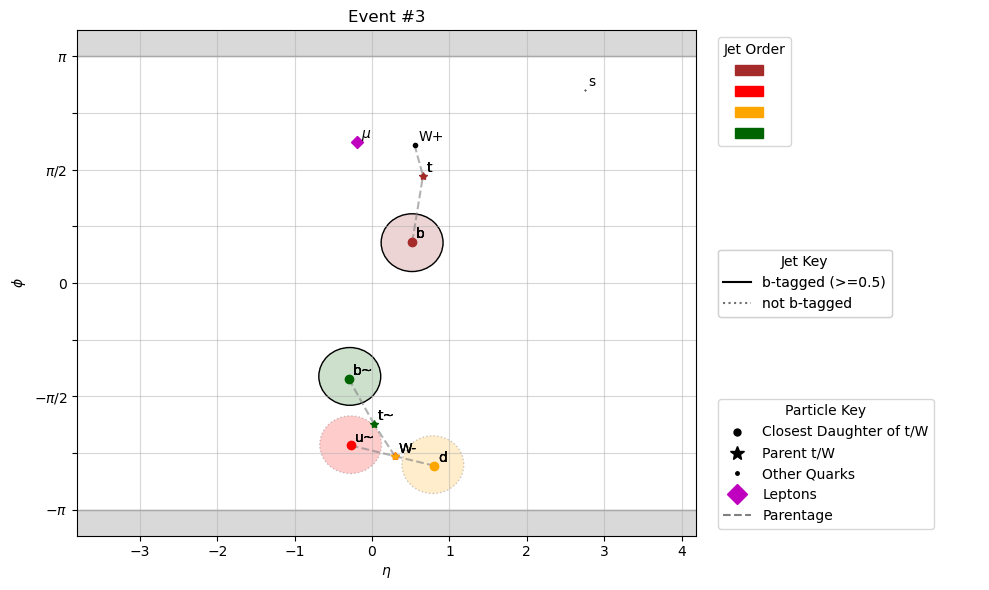

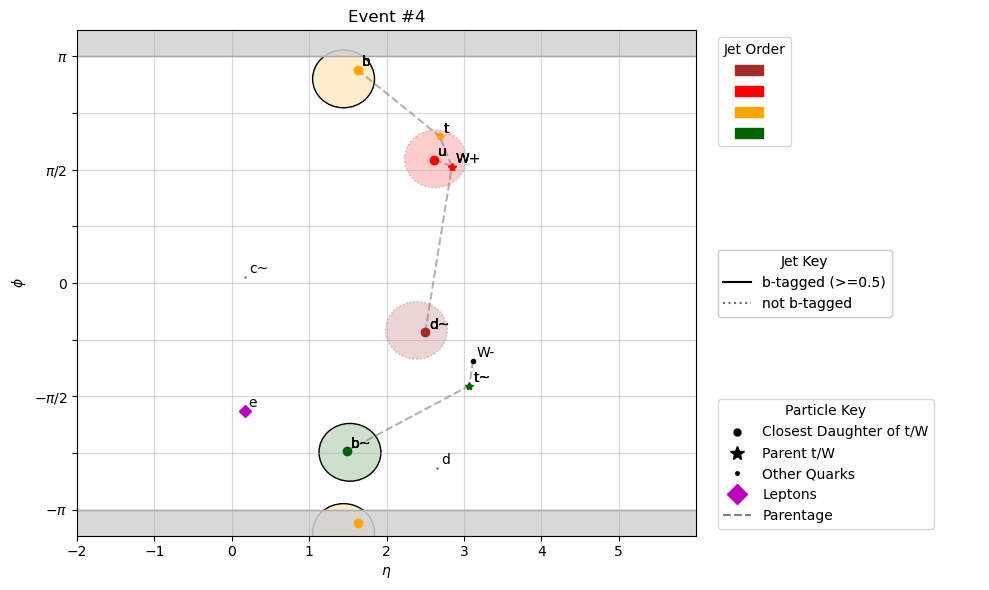

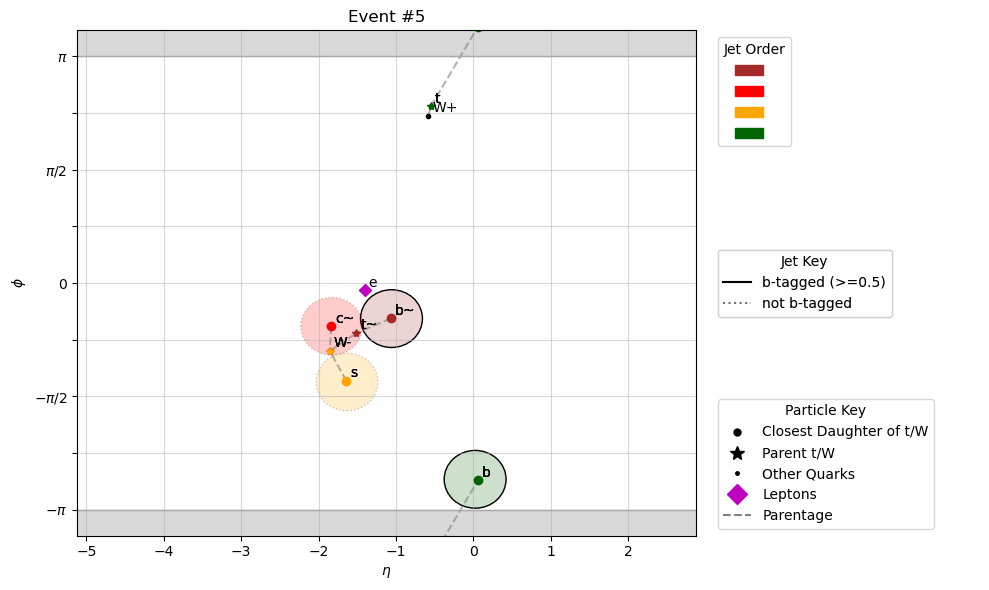

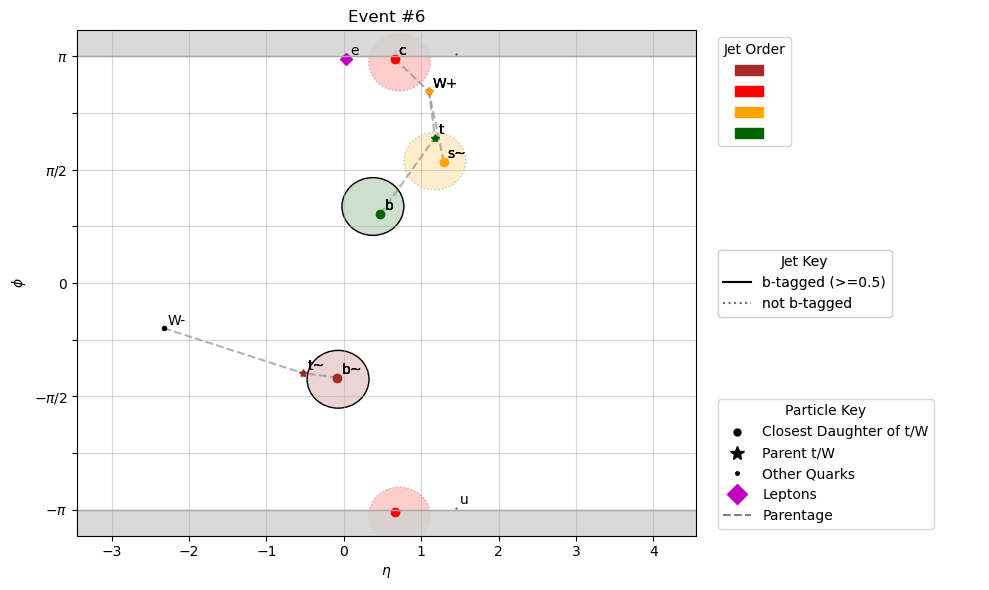

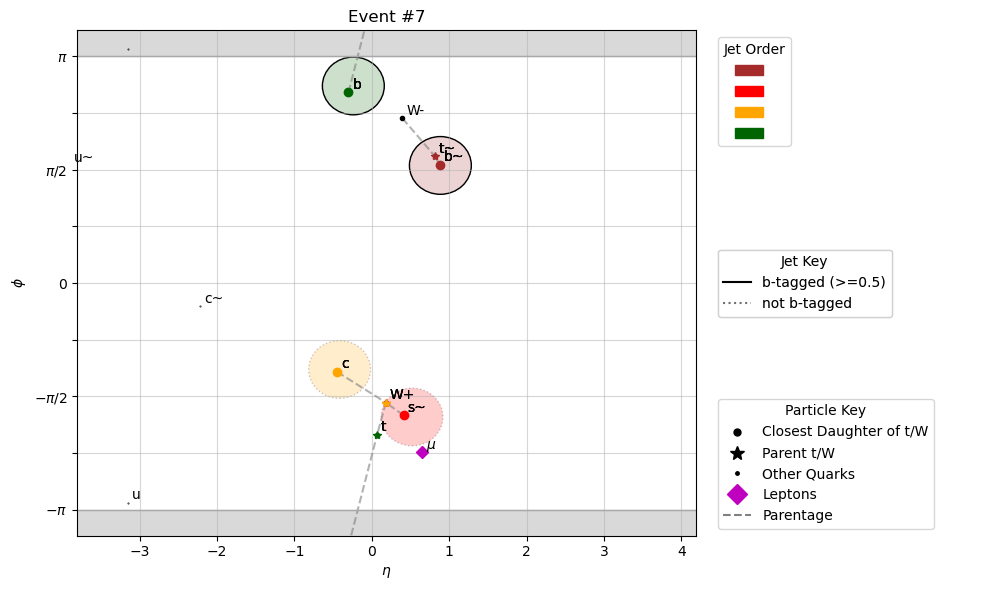

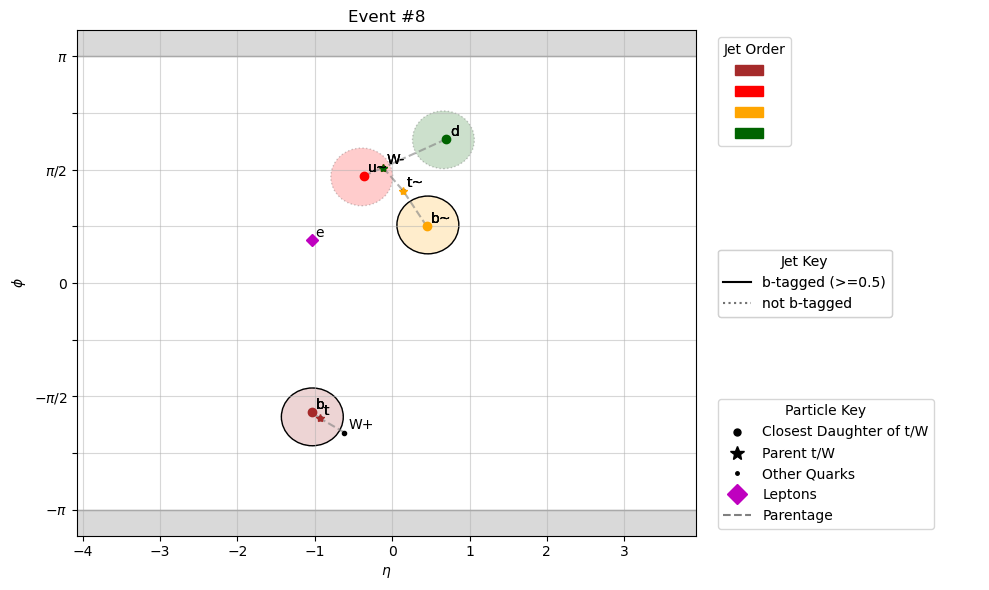

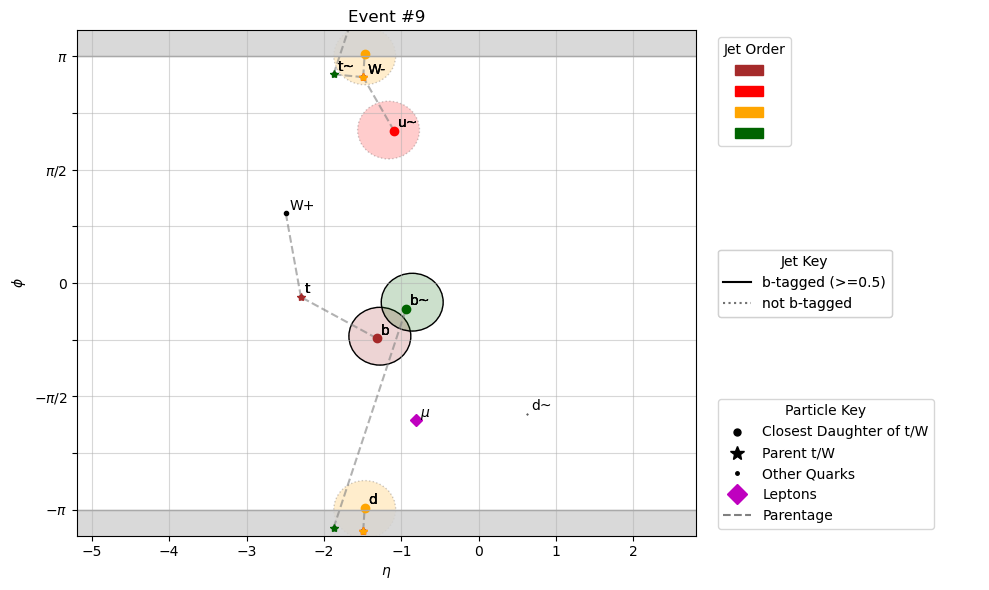

In [19]:
for iEvt in range(10):
    
    # define mpl figure
    fig,axs = plt.subplots(1,2,figsize=(10,6),gridspec_kw={'width_ratios': [2.3, 1]})
    
    # get eta and phi t/W and their quark daughters
    genpart_eta = plotting_candidates[iEvt].eta[(np.abs(plotting_candidates[iEvt].eta)<4)
                                                & (np.abs(plotting_candidates[iEvt].phi)<=np.pi)]
    genpart_phi = plotting_candidates[iEvt].phi[(np.abs(plotting_candidates[iEvt].eta)<4)
                                                & (np.abs(plotting_candidates[iEvt].phi)<=np.pi)]
    
    avg_jet_eta = np.average(selected_jets_region[iEvt].eta)
    
    # print particle name and draw lines to parents
    for i in range(len(plotting_candidates[iEvt])):
        
        # if in range
        if np.abs(plotting_candidates[iEvt][i].eta)<avg_jet_eta+4:
            
            # print text
            axs[0].text(plotting_candidates[iEvt][i].eta+0.05, 
                        plotting_candidates[iEvt][i].phi+0.05, 
                        f"{particle.Particle.from_pdgid(plotting_candidates[iEvt][i].pdgId).name}", 
                        fontsize=10)
        
            # if parent exists
            if plotting_candidates[iEvt][i].distinctParent is not None and not plotting_candidates[iEvt][i].genPartIdxMother==-1:
                
                # if in range
                if np.abs(plotting_candidates[iEvt][i].distinctParent.eta)<avg_jet_eta+4:
                
                    particle_parent_pair = np.array([plotting_candidates[iEvt][i], plotting_candidates[iEvt][i].distinctParent])

                    distances = [np.sqrt((particle_parent_pair[0].eta-particle_parent_pair[1].eta)**2 + 
                                         (particle_parent_pair[0].phi-particle_parent_pair[1].phi)**2),
                                 np.sqrt((particle_parent_pair[0].eta-particle_parent_pair[1].eta)**2 + 
                                         (particle_parent_pair[0].phi-particle_parent_pair[1].phi+2*np.pi)**2),
                                 np.sqrt((particle_parent_pair[0].eta-particle_parent_pair[1].eta)**2 + 
                                         (particle_parent_pair[0].phi-particle_parent_pair[1].phi-2*np.pi)**2)]

                    # draw line between particle and parent
                    if np.argmin(distances)==0:
                        axs[0].plot([particle_parent_pair[0].eta, particle_parent_pair[1].eta],
                                    [particle_parent_pair[0].phi, particle_parent_pair[1].phi],
                                    marker=None, linestyle='dashed', color='grey', alpha=0.6)
                    else: 
                        higher_particle = particle_parent_pair[np.argmax([particle_parent_pair[0].phi,particle_parent_pair[1].phi])]
                        lower_particle = particle_parent_pair[np.argmin([particle_parent_pair[0].phi,particle_parent_pair[1].phi])]
                        
                        axs[0].plot([higher_particle.eta, lower_particle.eta],
                                    [higher_particle.phi, lower_particle.phi+2*np.pi],
                                    marker=None, linestyle='dashed', color='grey', alpha=0.6)
                        axs[0].plot([higher_particle.eta, lower_particle.eta],
                                    [higher_particle.phi-2*np.pi, lower_particle.phi],
                                    marker=None, linestyle='dashed', color='grey', alpha=0.6)
                
    # plot t/W and their daughter quarks
    axs[0].plot(genpart_eta, genpart_phi, 'k.')
    axs[0].plot(genpart_eta, genpart_phi-2*np.pi, 'k.')
    axs[0].plot(genpart_eta, genpart_phi+2*np.pi, 'k.')
    
    # print particle name for all quarks
    for i in range(len(all_quarks[iEvt])):
        
        # if in range
        if ((np.abs(all_quarks[iEvt][i].eta)<4) & (np.abs(all_quarks[iEvt][i].phi)<=np.pi)):
            
            # print text
            axs[0].text(all_quarks[iEvt][i].eta+0.05, 
                        all_quarks[iEvt][i].phi+0.05, 
                        f"{particle.Particle.from_pdgid(all_quarks[iEvt][i].pdgId).name}", 
                        fontsize=10)
    
    # grab quark eta and phi
    quark_eta = all_quarks[iEvt].eta[(np.abs(all_quarks[iEvt].eta)<4) & (np.abs(all_quarks[iEvt].phi)<=np.pi)]
    quark_phi = all_quarks[iEvt].phi[(np.abs(all_quarks[iEvt].eta)<4) & (np.abs(all_quarks[iEvt].phi)<=np.pi)]
        
    # plot quarks
    axs[0].plot(quark_eta, quark_phi, 'k.',markersize=0.8)
    axs[0].plot(quark_eta, quark_phi-2*np.pi, 'k.',markersize=0.8)
    axs[0].plot(quark_eta, quark_phi+2*np.pi, 'k.',markersize=0.8)
    
    order_elements = []
    for i,jet in enumerate(selected_jets_region[iEvt]):
        # create circle centered around jet center with R=0.4
        circle = plt.Circle((jet.eta, jet.phi), 0.4, facecolor=jetcolors[i], edgecolor = 'k', linestyle='dotted', alpha=0.2)
        axs[0].add_patch(circle)
        
        if jet.phi>np.pi-0.4:
            circle2 = plt.Circle((jet.eta, jet.phi-2*np.pi), 0.4, facecolor=jetcolors[i], edgecolor = 'k', linestyle='dotted', alpha=0.2)
            axs[0].add_patch(circle2)
        elif jet.phi<-np.pi+0.4:
            circle2 = plt.Circle((jet.eta, jet.phi+2*np.pi), 0.4, facecolor=jetcolors[i], edgecolor = 'k', linestyle='dotted', alpha=0.2)
            axs[0].add_patch(circle2)
        
        
        # add border if b-tagged
        if jet.btagCSVV2>B_TAG_THRESHOLD:
            circle = plt.Circle((jet.eta, jet.phi), 0.4, facecolor=None, edgecolor = 'k', 
                                linestyle='solid', fill=False)
            if jet.phi>np.pi-0.4:
                circle2 = plt.Circle((jet.eta, jet.phi-2*np.pi), 0.4, facecolor=None, edgecolor = 'k', 
                                     linestyle='solid', fill=False)
                axs[0].add_patch(circle2)
            elif jet.phi<-np.pi+0.4:
                circle2 = plt.Circle((jet.eta, jet.phi+2*np.pi), 0.4, facecolor=None, edgecolor = 'k', 
                                     linestyle='solid', fill=False)
                axs[0].add_patch(circle2)
            else:
                circle2 = None
            
            axs[0].add_patch(circle)
            
        if nearest_genpart[iEvt][i] is not None:
            axs[0].plot(nearest_genpart[iEvt][i].eta,nearest_genpart[iEvt][i].phi,'o',color=jetcolors[i])
            axs[0].text(nearest_genpart[iEvt][i].eta+0.05,nearest_genpart[iEvt][i].phi+0.05,
                        f"{particle.Particle.from_pdgid(nearest_genpart[iEvt][i].pdgId).name}", 
                        fontsize=10)
            axs[0].plot(nearest_genpart[iEvt][i].eta,nearest_genpart[iEvt][i].phi-2*np.pi,'o',color=jetcolors[i])
            axs[0].plot(nearest_genpart[iEvt][i].eta,nearest_genpart[iEvt][i].phi+2*np.pi,'o',color=jetcolors[i])
            
            if nearest_parent[iEvt][i] is not None:
                axs[0].plot(nearest_parent[iEvt][i].eta,nearest_parent[iEvt][i].phi,'*',color=jetcolors[i])
                axs[0].text(nearest_parent[iEvt][i].eta+0.05,nearest_parent[iEvt][i].phi+0.05,
                            f"{particle.Particle.from_pdgid(nearest_parent[iEvt][i].pdgId).name}", 
                            fontsize=10)
                axs[0].plot(nearest_parent[iEvt][i].eta,nearest_parent[iEvt][i].phi-2*np.pi,'*',color=jetcolors[i])
                axs[0].plot(nearest_parent[iEvt][i].eta,nearest_parent[iEvt][i].phi+2*np.pi,'*',color=jetcolors[i])
                
        # add jet color info for legend
        order_elements.append(Patch(facecolor=jetcolors[i], edgecolor=jetcolors[i],label=''))
    
    # plot electrons
    axs[0].plot(selected_electrons[iEvt].eta, selected_electrons[iEvt].phi, 'mD')
    for i in range(len(selected_electrons[iEvt])):
        axs[0].text(selected_electrons[iEvt][i].eta+0.05, selected_electrons[iEvt][i].phi+0.05, "e", fontsize=10)
    
    # plot muons
    axs[0].plot(selected_muons[iEvt].eta, selected_muons[iEvt].phi, 'mD')
    for i in range(len(selected_muons[iEvt])):
        axs[0].text(selected_muons[iEvt][i].eta+0.05, selected_muons[iEvt][i].phi+0.05, "$\mu$", fontsize=10)
    
    
    # legend for jet order
    legend1 = plt.legend(handles=order_elements, 
                         title="Jet Order", 
                         loc='upper left')
    
    # legend for particles
    particle_legend_elements = [Line2D([0], [0], marker='.', color='k', label='Closest Daughter of t/W', 
                                       markersize=10, linestyle='None'),
                                Line2D([0], [0], marker='*', color='k', label='Parent t/W', 
                                       markersize=10, linestyle='None'),
                                Line2D([0], [0], marker='.', color='k', label='Other Quarks', 
                                       markersize=5, linestyle='None'),
                                Line2D([0], [0], marker='D', color='m', label='Leptons', 
                                       markersize=10, linestyle='None'),
                                Line2D([0], [0], marker=None, color='gray', label='Parentage', 
                                       linestyle='dashed')]
    
    legend2 = plt.legend(handles=particle_legend_elements, 
                         title="Particle Key", 
                         loc='lower left')
    
    # legend for jets
    jet_legend_elements = [Line2D([0], [0], marker=None, color='k', label=f'b-tagged (>={B_TAG_THRESHOLD})', 
                                  linestyle='solid',alpha=1.0),
                           Line2D([0], [0], marker=None, color='k', label='not b-tagged', 
                                  linestyle='dotted',alpha=0.5)]
    
    legend3 = plt.legend(handles=jet_legend_elements, 
                         title="Jet Key", 
                         loc='center left')
    
    # marks pi and -pi on plot
    axs[0].hlines([-np.pi, np.pi], -10, 10, color='darkgray', alpha=1.0, linewidth=1)
    
    # add legends to plot
    axs[1].add_artist(legend1)
    axs[1].add_artist(legend2)
    axs[1].add_artist(legend3)
    
    # shade areas outside phi=(-pi,pi)
    axs[0].fill_between([-10,10],np.pi,np.pi+1,color='lightgray',alpha=0.85)
    axs[0].fill_between([-10,10],-1-np.pi,-np.pi,color='lightgray',alpha=0.85)
    
    # plotting limits
    axs[0].set_xlim([avg_jet_eta-4,avg_jet_eta+4])
    axs[0].set_ylim([-3.5,3.5])
    
    # set axis labels
    axs[0].set_xlabel("$\eta$")
    axs[0].set_ylabel("$\phi$")
    
    # phi axis in units of pi
    # axs[0].yaxis.set_major_formatter(FormatStrFormatter('%g $\pi$'))
    # axs[0].yaxis.set_major_locator(MultipleLocator(base=np.pi))
    axs[0].set_yticks([-np.pi,-3*np.pi/4,-np.pi/2,-np.pi/4,0,np.pi/4,np.pi/2,3*np.pi/4,np.pi])
    axs[0].set_yticklabels(["$-\pi$","","$-\pi/2$","","0","","$\pi/2$","","$\pi$"])
    
    axs[0].grid(alpha=0.5)
    axs[0].set_title(f"Event #{iEvt}")
    
    # make second subplot invisible (just used to get legends to show up nicely)
    axs[1].spines['top'].set_visible(False)
    axs[1].spines['right'].set_visible(False)
    axs[1].spines['bottom'].set_visible(False)
    axs[1].spines['left'].set_visible(False)
    axs[1].get_xaxis().set_ticks([])
    axs[1].get_yaxis().set_ticks([])
    
    
    
    fig.tight_layout()
    
    plt.show()